In [16]:
# autorelead libraries
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'


In [18]:
import time
import random
import pickle
import argparse
import gc

import numpy as np
import scipy.sparse as sp
import scipy.signal as sig
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader

from config import get_config
from dataset import data_loader

In [19]:
def calcMetrics(input_data, sampFreq, B, window_size=None, use_harmonic=False, normalize=False):
    # define goodness parameters
    B1 = 0.75 # low cutoff
    B2 = 3 # high cutoff

    if window_size is None:
        pulseCalcLength = len(input_data)
    else:
        pulseCalcLength = np.uint32(window_size/(1.0/sampFreq))
    pulseRate_result = np.empty(len(input_data)-pulseCalcLength + 1)
    goodnessMetric_result = np.empty(len(input_data)-pulseCalcLength + 1)

    for i in range(0, len(pulseRate_result)):
        window = input_data[i:i+pulseCalcLength]
        # ppgFreq, ppgPower = sig.periodogram(window, fs=sampFreq, nfft=180000)
        ppgFreq, ppgPower = sig.welch(x=window, nperseg=len(window)//3, fs=sampFreq, nfft=180000)
        maskFreq = (ppgFreq > B1)&(ppgFreq<B2)
        # ppgFreq = ppgFreq[maskFreq]
        ppgPower = ppgPower * maskFreq
        if use_harmonic:
            # harmonic PSD
            harmonicppgPower = ppgPower[::2]
            harmonicppgPower = np.pad(harmonicppgPower, (0, len(ppgPower) - len(harmonicppgPower)))
            # find peak frequency
            peakFreq = ppgFreq[np.argmax(ppgPower + harmonicppgPower)]
        else:
            peakFreq = ppgFreq[np.argmax(ppgPower)]
        pulseRate = 60.0*peakFreq
        pulseRate_result[i] = pulseRate
        # compute goodness
        aroundPulseRate = (ppgFreq > peakFreq - B) & (ppgFreq < peakFreq + B)
        withinBandpass = (ppgFreq >= B1) & (ppgFreq <= B2)
        powerPulseRate = np.sum(ppgPower[aroundPulseRate])
        powerAll = np.sum(ppgPower[withinBandpass])
        if normalize:
            goodnessMetric_result[i] = powerPulseRate / powerAll
        else:
            goodnessMetric_result[i] = powerPulseRate / (powerAll - powerPulseRate)
    timestamps = np.arange(len(pulseRate_result))
    return timestamps, goodnessMetric_result, pulseRate_result

def custom_detrend(sig, Lambda):
    """custom_detrend(sig, Lambda) -> filtered_signal
    This function applies a detrending filter.
    This code is based on the following article "An advanced detrending method with application
    to HRV analysis". Tarvainen et al., IEEE Trans on Biomedical Engineering, 2002.
    *Parameters*
      ``sig`` (1d numpy array):
        The sig where you want to remove the trend.
      ``Lambda`` (int):
        The smoothing parameter.
    *Returns*
      ``filtered_signal`` (1d numpy array):
        The detrended sig.
    """
    signal_length = sig.shape[0]

    # observation matrix
    H = np.identity(signal_length)

    # second-order difference matrix

    ones = np.ones(signal_length)
    minus_twos = -2 * np.ones(signal_length)
    diags_data = np.array([ones, minus_twos, ones])
    diags_index = np.array([0, 1, 2])
    D = sp.spdiags(diags_data, diags_index, (signal_length - 2), signal_length).toarray()
    filtered_signal = np.dot((H - np.linalg.inv(H + (Lambda ** 2) * np.dot(D.T, D))), sig)
    return filtered_signal

def pulse_rate_from_power_spectral_density(pleth_sig: np.array, FS: float,
                                           LL_PR: float, UL_PR: float,
                                           BUTTER_ORDER: int = 6,
                                           DETREND: bool = False,
                                           FResBPM: float = 0.1,
                                           HARMONIC: bool = False,
                                           WELCH = True) -> float:
    """ Function to estimate the pulse rate from the power spectral density of the plethysmography sig.

    Args:
        pleth_sig (np.array): Plethysmography sig.
        FS (float): Sampling frequency.
        LL_PR (float): Lower cutoff frequency for the butterworth filtering.
        UL_PR (float): Upper cutoff frequency for the butterworth filtering.
        BUTTER_ORDER (int, optional): Order of the butterworth filter. Give None to skip filtering. Defaults to 6.
        DETREND (bool, optional): Boolena Flag for executing cutsom_detrend. Defaults to False.
        FResBPM (float, optional): Frequency resolution. Defaults to 0.1.

    Returns:
        pulse_rate (float): _description_
    

    Daniel McDuff, Ethan Blackford, January 2019
    Copyright (c)
    Licensed under the MIT License and the RAIL AI License.
    """

    N = (60*FS)/FResBPM

    # Detrending + nth order butterworth + periodogram
    if DETREND:
        pleth_sig = custom_detrend(pleth_sig, 100)
    if BUTTER_ORDER:
        [b, a] = sig.butter(BUTTER_ORDER, [LL_PR/60, UL_PR/60], btype='bandpass', fs = FS)
    pleth_sig = sig.filtfilt(b, a, np.double(pleth_sig))
    
    # Calculate the PSD and the mask for the desired range
    if WELCH:
        F, Pxx = sig.welch(x=pleth_sig, nperseg=len(pleth_sig)//3, nfft=N, fs=FS)
    else:
        F, Pxx = sig.periodogram(x=pleth_sig,  nfft=N, fs=FS);  
    FMask = (F >= (LL_PR/60)) & (F <= (UL_PR/60))
    
    # Calculate predicted pulse rate:
    FRange = F * FMask
    PRange = Pxx * FMask

    if HARMONIC:
      harmonicppgPower = PRange[::2]
      harmonicppgPower = np.pad(harmonicppgPower, (0, len(PRange) - len(harmonicppgPower)))
      harmonicppgPower[0] = 0
      MaxInd = np.argmax(PRange+harmonicppgPower)
    else:
      MaxInd = np.argmax(PRange)
    pulse_rate_freq = FRange[MaxInd]
    pulse_rate = pulse_rate_freq*60
            
    return pulse_rate

In [35]:
class Args:
    config_file = 'configs/train_configs/CogPhys_RHYTHMFORMER_BASIC.yaml'
    cached_path = None
    preprocess = None
    lr = None
    model_file_name = None

args = Args()
config = get_config(args)

# print('Configuration:')
# print(config, end='\n\n')
data_loader_dict = dict() # dictionary of data loaders 
train_loader = data_loader.CogPhysLoader.CogPhysLoader
print(config.DEVICE)
train_data_loader = train_loader(
    name="train",
    data_path=config.TRAIN.DATA.DATA_PATH,
    config_data=config.TRAIN.DATA,
    device=config.DEVICE)
data_loader_dict['train'] = DataLoader(
    dataset=train_data_loader,
    num_workers=2,
    batch_size=2,
    shuffle=True,
)
print(); print()

valid_loader = data_loader.CogPhysLoader.CogPhysLoader
print(config.DEVICE)
valid_data_loader = valid_loader(
    name="valid",
    data_path=config.VALID.DATA.DATA_PATH,
    config_data=config.VALID.DATA,
    device=config.DEVICE)
data_loader_dict['valid'] = DataLoader(
    dataset=valid_data_loader,
    num_workers=2,
    batch_size=2,
    shuffle=True,
)
print(); print()

test_loader = data_loader.CogPhysLoader.CogPhysLoader
print(config.DEVICE)
test_data_loader = test_loader(
    name="test",
    data_path=config.TEST.DATA.DATA_PATH,
    config_data=config.TEST.DATA,
    device=config.DEVICE)
data_loader_dict['test'] = DataLoader(
    dataset=test_data_loader,
    num_workers=2,
    batch_size=2,
    shuffle=False,
)




=> Merging a config file from configs/train_configs/CogPhys_RHYTHMFORMER_BASIC.yaml
cuda:0
Cached Data Path /shared/ab227/CogPhys/chunked_dataset

Data Path /shared/ab227/CogPhys/chunked_dataset

train Preprocessed Dataset Length: 1776



cuda:0
Cached Data Path /shared/ab227/CogPhys/chunked_dataset

Data Path /shared/ab227/CogPhys/chunked_dataset

valid Preprocessed Dataset Length: 144



cuda:0
Cached Data Path /shared/ab227/CogPhys/chunked_dataset

Data Path /shared/ab227/CogPhys/chunked_dataset

test Preprocessed Dataset Length: 720



In [36]:
test_data_loader.input_preproc, test_data_loader.label_preproc, test_data_loader.input_keys, test_data_loader.label_keys

([['NormAndFloat']], [['Standardize', 'Downsample']], ['rgb_left'], ['ppg'])

In [37]:
torch.cuda.empty_cache()

In [38]:
from neural_methods.model.RhythmFormer import RhythmFormer

model = RhythmFormer().to(config.DEVICE).eval()

saved_path = 'runs/exp/RGB_RhythmFormer/PreTrainedModels/CogPhys_rPPG_ch3_RhythmFormer_Epoch29.pth'
state_dict = torch.load(saved_path, map_location=config.DEVICE)

# Remove 'module.' prefix because when trained with DataParallel this is added
new_state_dict = {k.replace('module.', ''): v for k, v in state_dict.items()}

model.load_state_dict(new_state_dict)

model = torch.nn.DataParallel(model, device_ids=list(range(config.NUM_OF_GPU_TRAIN)))


# # Enable dropout only
# for module in model.modules():
#     if isinstance(module, torch.nn.Dropout3d):
#         module.train()

In [42]:
all_rppg_hr = []
all_ppg_hr = []
all_goodness = []
all_rppg = []
all_ppg = []
for i in range(0, len(test_data_loader), 12):
    for j in [[0, 1, 4], [5, 6, 7], [8, 9, 10], [11, 2, 3]]:
        img = []
        rppg = []  
        label = []
        participant_task_list = []
        chunk_id_list = []
        with torch.no_grad():
            for k in j:
                img_sample, label_sample, participant_task, chunk_id = test_data_loader[i+k]
                participant_task_list.append(participant_task)
                chunk_id_list.append(int(chunk_id))
                img.append(img_sample.to(config.DEVICE))

                label.extend(label_sample.squeeze(0).cpu().numpy().tolist())
                # rppg_sample_fft = np.fft.fft(rppg_sample, axis=0)
                # rppg_sample_abs = np.abs(rppg_sample_fft).mean(0)
                # rppg_sample_angle = np.angle(rppg_sample_fft).mean(0)
                # rppg_sample = np.fft.ifft(rppg_sample_abs * np.exp(1j * rppg_sample_angle), axis=0).real
                # rppg_sample = torch.Tensor(rppg_sample).unsqueeze(0)
            img = torch.cat(img, dim=1).unsqueeze(0)
            
            rppg = model(img).squeeze(0).cpu().numpy()

            
        if "v23_read" == participant_task:
            print("Skipping")
            print("-"*100)
            continue
        if "v3_" in participant_task:
            print("Skipping")
            print("-"*100)
            continue
        ##################
        assert participant_task_list[0] == participant_task_list[1] == participant_task_list[2]
        assert chunk_id_list[0] == chunk_id_list[1]-1 == chunk_id_list[2]-2
        ##################
        rppg = np.array(rppg)
        label = np.array(label)
        
        # Detrend and Goodness
        goodness = calcMetrics(rppg, 30, 0.1, normalize=True)[1][0]
        # 1-D gauss blur
        rppg = custom_detrend(rppg, 100)
        smooth_kernel = np.ones(7) / 7
        rppg = sig.convolve(rppg, smooth_kernel, mode='same')
        # Norm
        rppg = (rppg - np.mean(rppg)) / np.std(rppg)
        label = (label - np.mean(label)) / np.std(label)
        # HR
        rppg_hr = pulse_rate_from_power_spectral_density(rppg, 30, 50, 180, BUTTER_ORDER=6, DETREND=False, WELCH=True)
        ppg_hr = pulse_rate_from_power_spectral_density(label, 30, 50, 180, BUTTER_ORDER=6, DETREND=False, WELCH=True)
        all_rppg_hr.append(rppg_hr)
        all_ppg_hr.append(ppg_hr)
        all_goodness.append(goodness)
        # # FFT
        rppg_x, rrpg_fft_welch = sig.welch(rppg, fs=30, nperseg=len(rppg)//3, nfft=18000)
        ppg_x, ppg_fft_welch = sig.welch(label, fs=30, nperseg=len(label)//3, nfft=18000)
        # rppg_x, rrpg_fft_welch = sig.periodogram(rppg, fs=30, nfft=18000)
        # ppg_x, ppg_fft_welch = sig.periodogram(label, fs=30, nfft=18000)
        # # plt subplot 1x2 figsize=(20, 5)
        # plt.figure(figsize=(20, 5))
        # plt.subplot(1, 2, 1)
        # plt.plot(rppg, '-', label='rppg')
        # plt.plot(label, '--', label='ppg')
        # plt.legend()
        # plt.subplot(1, 2, 2)
        # plt.plot(rppg_x*60, rrpg_fft_welch, '-', label='rppg')
        # plt.plot(ppg_x*60, ppg_fft_welch, '--', label='ppg')
        # plt.legend()
        # plt.xlim(45, 180)
        # plt.suptitle(f"| {rppg_hr:.2f} - {ppg_hr:.2f} | = {abs(rppg_hr - ppg_hr):.2f} bpm")
        # plt.show()
        all_rppg.append(rppg)
        all_ppg.append(label)
        print(participant_task_list[0], chunk_id_list)
        print(f"| {rppg_hr:.2f} - {ppg_hr:.2f} | = {abs(rppg_hr - ppg_hr):.2f} bpm\t\t\t{goodness:.2f}")
        print("-"*100)
        
        # After you're done with rppg
        del img, img_sample, label_sample, rppg
        torch.cuda.empty_cache()
        gc.collect()


all_rppg_hr = np.array(all_rppg_hr)
all_ppg_hr = np.array(all_ppg_hr)
all_goodness = np.array(all_goodness)

v22_pattern_rest [0, 1, 2]
| 80.20 - 91.80 | = 11.60 bpm			0.45
----------------------------------------------------------------------------------------------------
v22_pattern_rest [3, 4, 5]
| 74.10 - 95.30 | = 21.20 bpm			0.55
----------------------------------------------------------------------------------------------------
v22_pattern_rest [6, 7, 8]
| 80.10 - 85.30 | = 5.20 bpm			0.68
----------------------------------------------------------------------------------------------------
v22_pattern_rest [9, 10, 11]
| 81.30 - 86.30 | = 5.00 bpm			0.69
----------------------------------------------------------------------------------------------------
v27_number [0, 1, 2]
| 82.00 - 84.60 | = 2.60 bpm			0.68
----------------------------------------------------------------------------------------------------
v27_number [3, 4, 5]
| 79.90 - 79.20 | = 0.70 bpm			0.68
----------------------------------------------------------------------------------------------------
v27_number [6, 7, 8]
| 7

In [ ]:
a, b = sig.butter(6, [50/60, 180/60], btype='bandpass', fs=30)
for rppg, ppg, rrpg_hr, ppg_hr, goodness in zip(all_rppg, all_ppg, all_rppg_hr, all_ppg_hr, all_goodness):
    # rppg = custom_detrend(rppg, 100)
    # guass_kernel = sig.gaussian(7, std=4)
    # rppg = sig.convolve(rppg, guass_kernel, mode='same')

    # ppg = custom_detrend(ppg, 100)
    # guass_kernel = sig.gaussian(7, std=4)
    # guass_kernel /= np.sum(guass_kernel)
    # ppg = sig.convolve(ppg, guass_kernel, mode='same')
    # 1x2 figure with first plot twice as big as second
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5), gridspec_kw={'width_ratios': [5, 2]})
    # reduce space between subplots
    plt.subplots_adjust(wspace=0.05)
    # plot rppg
    ax1.plot(rppg, '-', label='rppg')
    ax1.plot(ppg, '--', label='ppg')
    ax1.legend()
    # plot fft
    rppg_x, rrpg_fft_welch = sig.welch(rppg, fs=30, nperseg=len(rppg)//3, nfft=18000)
    ppg_x, ppg_fft_welch = sig.welch(ppg, fs=30, nperseg=len(ppg)//3, nfft=18000)
    ax2.plot(rppg_x*60, rrpg_fft_welch, '-', label='rppg')
    ax2.plot(ppg_x*60, ppg_fft_welch, '--', label='ppg')
    ax2.legend()
    ax2.set_xlim(45, 180)
    ax1.set_title(f"| {rrpg_hr:.2f} - {ppg_hr:.2f} | = {abs(rrpg_hr - ppg_hr):.2f} bpm         {goodness:.2f}")
    plt.show()

7.73177966101695 7.569657217610894
195 236
4.960000000000002 4.3934730143936385
236 236
7.73177966101695 7.569657217610894


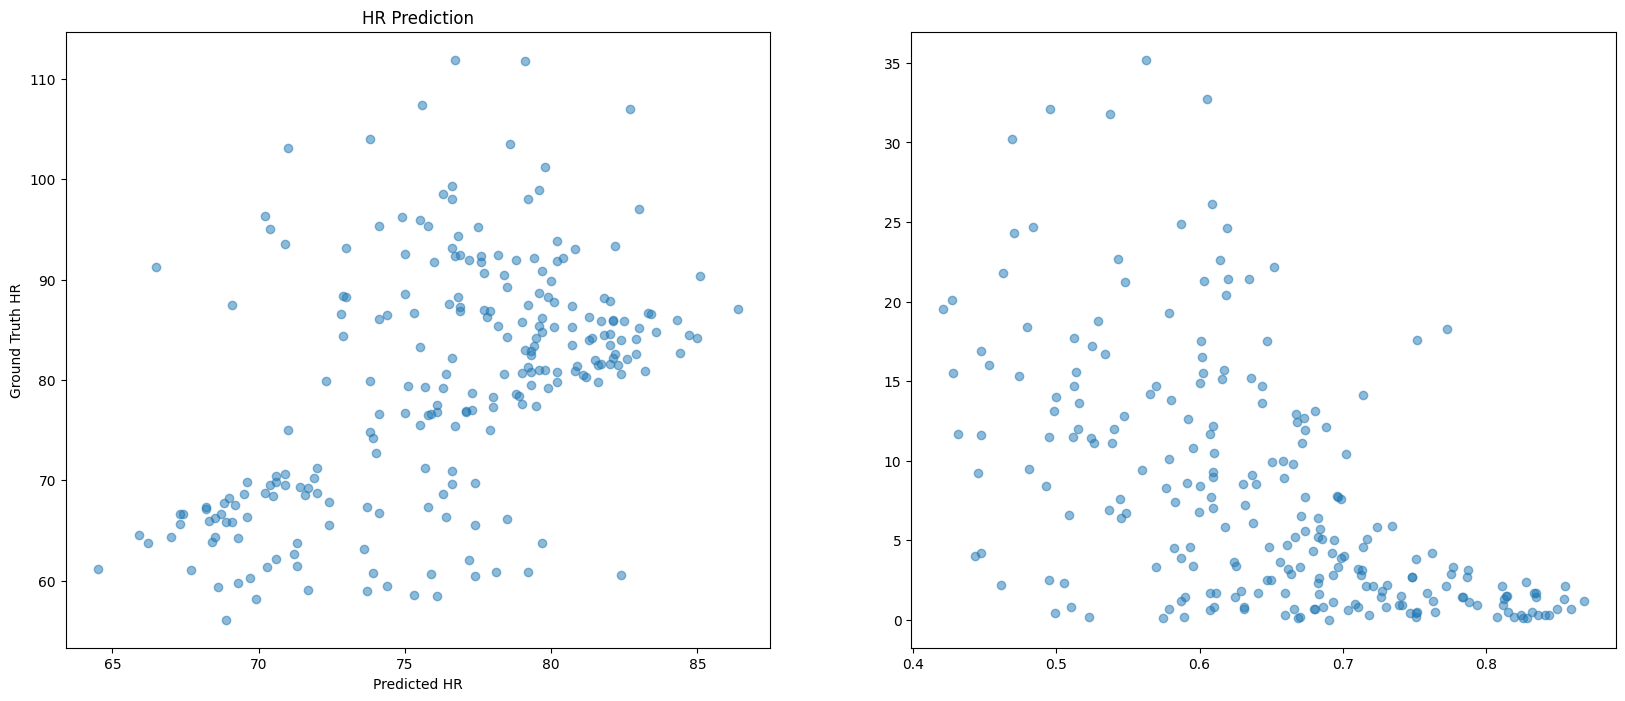

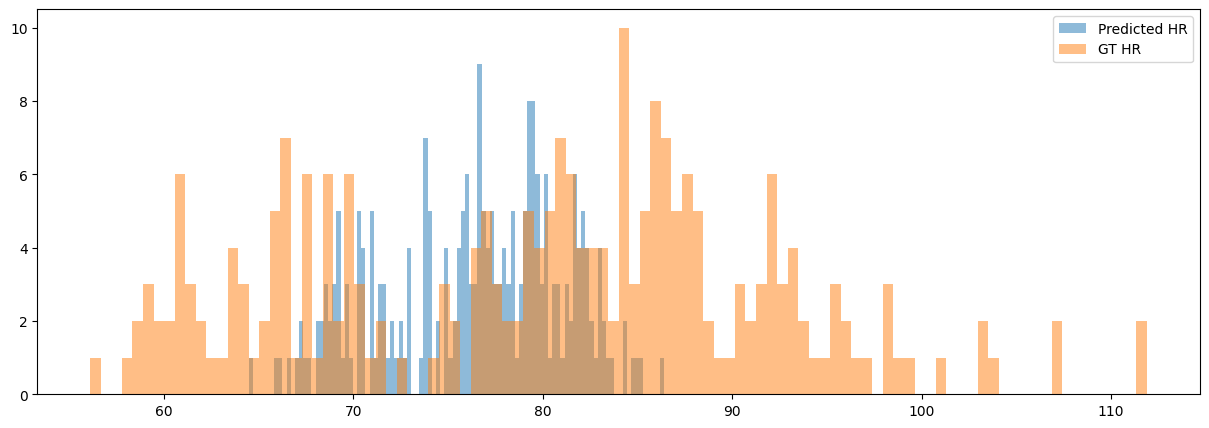

In [43]:
all_errors = np.abs(all_rppg_hr - all_ppg_hr)
print(np.mean(all_errors), np.std(all_errors))
print(np.sum(all_errors < 15), len(all_errors))
print(all_errors[all_errors < 15].mean(), all_errors[all_errors < 15].std())
print(len(all_errors[all_goodness > 0.4]), len(all_errors))
print(all_errors[all_goodness > 0.4].mean(), all_errors[all_goodness > 0.4].std())
# 1x2 plot
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(all_rppg_hr, all_ppg_hr, 'o', alpha=0.5)
plt.xlabel('Predicted HR')
plt.ylabel('Ground Truth HR')
plt.title('HR Prediction') 
plt.subplot(1, 2, 2)
plt.plot(all_goodness, all_errors, 'o', alpha=0.5)
plt.show()

plt.figure(figsize=(15, 5))
plt.hist(np.array(all_rppg_hr), bins=100, alpha=0.5, label='Predicted HR')
plt.hist(np.array(all_ppg_hr), bins=100, alpha=0.5, label='GT HR')
plt.legend()
plt.show()